# Team 1 CS 105 Final Project Data Processing and Analysis

Now, let's process our files.

In [1]:
import os
#import shutil
import numpy as np

import codecs
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

neg_dir = 'Project Datasets/neg'
pos_dir = 'Project Datasets/pos'

indices = []
train = []

for file in os.listdir(os.path.join(os.getcwd(), neg_dir)):
    f = os.path.join(os.getcwd(), neg_dir, file)
    text_input = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
    text = text_input.read()
    train.append(text)
    indices.append(file[:-4])
    text_input.close()

for file in os.listdir(os.path.join(os.getcwd(), pos_dir)):
    f = os.path.join(os.getcwd(), pos_dir, file)
    text_input = codecs.open(f, 'r', encoding='utf-8', errors='ignore')
    text = text_input.read()
    train.append(text)
    indices.append(file[:-4])
    text_input.close()

*EDA*

Something that might be interesting would be to visualize the most frequent words used in a negative review versus a positive one. For this, we can use word clouds. The first word cloud shown is for our negative reviews and the second one is for our positive reviews.

When initially making the word clouds, we noticed that there were many shared words between negative and positive reviews. Of course, this is proably due to common words having very high counts. Word cloud doesn't support a normalization function such as idf, so to combat this problem, we set the minimum word length to 9 characters and removed words that would be common to both negative and positive reviews, such as 'something' and 'character'. 

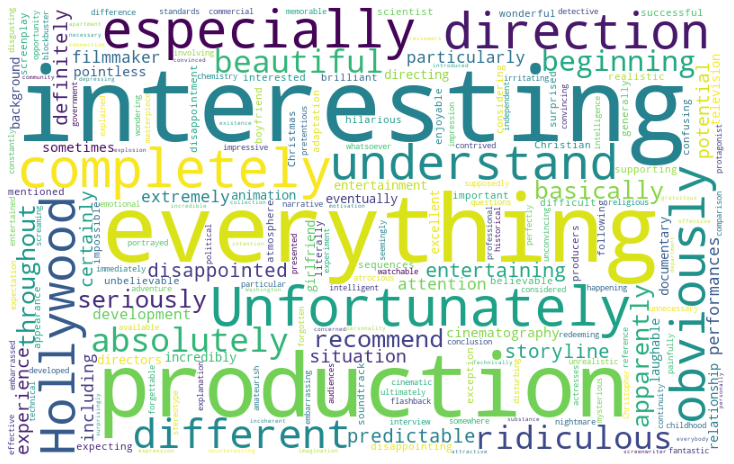

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

df = pd.DataFrame(train, columns=['review'])
df['label'] = 'Negative'
df.iloc[2500:,-1] = 'Positive'

negative = df['review'][df['label']=='Negative']

stopwords = set(STOPWORDS)
stopwords.add('something')
stopwords.add('performance')
stopwords.add('character')
stopwords.add('characters')

negative_wc = WordCloud(width=800,height=500,background_color='white', stopwords=stopwords, min_word_length=9).generate(' '.join(negative))

plt.figure(figsize=(10,8))
plt.imshow(negative_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

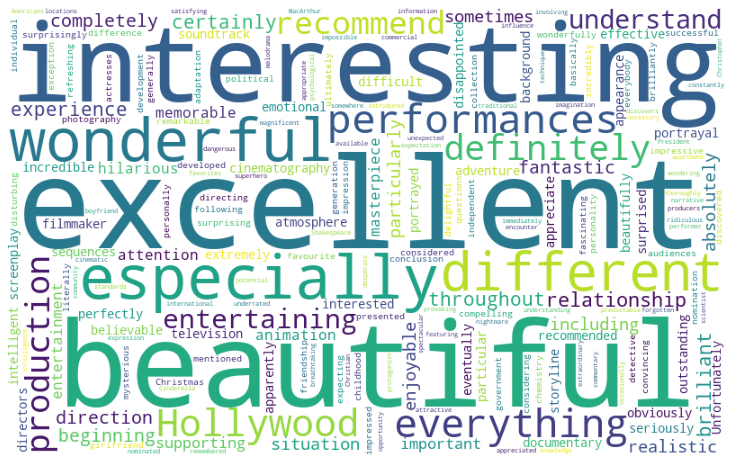

In [5]:
positive = df['review'][df['label']=='Positive']

positive_wc = WordCloud(width=800,height=500,background_color='white', stopwords=stopwords, min_word_length=9).generate(' '.join(positive))

plt.figure(figsize=(10,8))
plt.imshow(positive_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Now, let's build the vocabulary for our bag-of-worlds model and vectorize our documents

In [ ]:
# Tf-IDF Vectorizor
# Don't indlude stop words in vocabulary
# Only include tokens that appear in at least 10 documents
# Remove strictly numeric tokens
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words='english', min_df=10,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

tfidf_word_matrix = tfidfvectorizer.fit_transform(train)
tfidf_tokens = tfidfvectorizer.get_feature_names()

df_tfidf = pd.DataFrame(data = tfidf_word_matrix.toarray(), index = indices, columns = tfidf_tokens)

# Labelling data
df_tfidf['LABEL'] = 'Negative'
df_tfidf.iloc[2500:,-1] = 'Positive'

df_tfidf

Now, let's create our train and test sets. We will first look at how Gaussian Naive Bayes performs.

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Creating Train and Test sets
X = np.array(df_tfidf.drop(['LABEL'], axis=1))
Y = np.array(df_tfidf['LABEL'])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=123)

naive = GaussianNB()
naive.fit(X_train, Y_train)

Y_pred_NB = naive.predict(X_test)
print('Accuracy using Gaussian Naive Bayes =', accuracy_score(Y_test, Y_pred_NB))
scores = cross_val_score(naive, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using Gaussian Naive Bayes = 0.726
[0.58 0.65 0.62 0.6  0.58]
0.61 accuracy with a standard deviation of 0.03


In [29]:
# Print Classification Report
print(classification_report(Y_test, Y_pred_NB))

              precision    recall  f1-score   support

    Negative       0.71      0.77      0.74       253
    Positive       0.74      0.68      0.71       247

    accuracy                           0.73       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.73      0.73      0.73       500



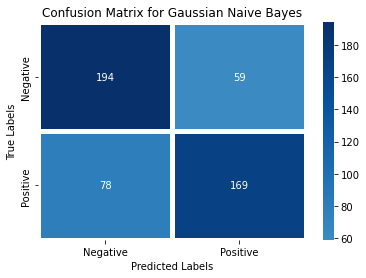

In [30]:
import seaborn as sns

# Plot Confusion matrix heatmap
cf = confusion_matrix(Y_test, Y_pred_NB)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Gaussian Naive Bayes')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

As you can see from the confusion matrix, from our test set, we correctly classified 183 negative reviews correctly and 178 positive reviews correctly. We incorrectly classified 70 negative reviews as positive and 69 positive reviews as negative. Let's now test how a SVM model will perform using the same train and test sets.

In [31]:
from xgboost import XGBClassifier

clf = XGBClassifier(subsample = 0.7, max_depth = 5)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using XGBoost =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy using XGBoost = 0.798
[16:50:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.7  0.72 0.71 0.68 0.69]
0.70 accuracy with a standard deviation of 0.01


In [32]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(splitter="random")
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using Decision Tree =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using Decision Tree = 0.706
[0.65 0.62 0.57 0.66 0.61]
0.62 accuracy with a standard deviation of 0.03


In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using Random Forest =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Accuracy using Random Forest = 0.786
[0.73 0.73 0.76 0.7  0.67]
0.72 accuracy with a standard deviation of 0.03


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error


clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print('Accuracy using SVM =', accuracy_score(Y_test, Y_pred))
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Accuracy using SVM = 0.832
[0.77 0.8  0.8  0.73 0.75]
0.77 accuracy with a standard deviation of 0.03


In [36]:
# Print Classification Report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

    Negative       0.83      0.84      0.83       253
    Positive       0.83      0.83      0.83       247

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



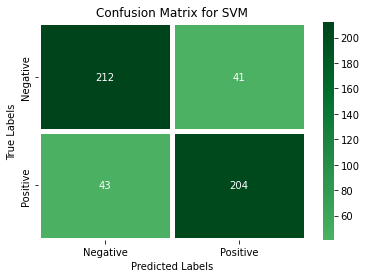

In [37]:
# Plot Confusion matrix heatmap
cf = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Greens", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

As you can see from the confusion matrix, from our test set, we correctly classified 205 negative reviews correctly and 214 positive reviews correctly. We incorrectly classified 48 negative reviews as positive and 33 positive reviews as negative. Our SVM model performs slightly better than Gaussian Naive Bayes, so we will save SVM as our final model.

In [38]:
import pickle

filename = 'review_classifier.pkl'
f = open(filename, 'wb')
pickle.dump(clf, f)
f.close()